### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 1.5 MB/s eta 0:00:00


### Import Dataset

In [3]:
online = pd.read_excel("../input/online-retail-uk/Online Retail.xlsx")
online.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


**Data Information**

In [4]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Select Relevant Columns**

In [5]:
online = online[["CustomerID", "InvoiceNo", "InvoiceDate", "UnitPrice", "Quantity"]].dropna()

In [6]:
online = online[(online["Quantity"] > 0) & (online["UnitPrice"] > 0)]

### Monthly Cohort

In [7]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

online["InvoiceMonth"] = online["InvoiceDate"].apply(get_month)

online["CohortMonth"] = online.groupby("CustomerID")["InvoiceMonth"].transform("min")
online.sample(5)

,CustomerID,InvoiceNo,InvoiceDate,UnitPrice,Quantity,InvoiceMonth,CohortMonth
181172,13752.0,552452,2011-05-09 14:02:00,1.25,1,2011-05-01,2011-04-01
413195,16905.0,572307,2011-10-23 15:23:00,2.10,1,2011-10-01,2010-12-01
451693,12949.0,575221,2011-11-09 11:25:00,0.42,25,2011-11-01,2011-04-01
354732,16389.0,567894,2011-09-22 15:54:00,5.95,6,2011-09-01,2011-03-01
172545,18062.0,551546,2011-05-03 09:34:00,4.15,8,2011-05-01,2011-01-01


**Cohort Index**

In [8]:
def get_date_int(online, column):
    year = online[column].dt.year
    month = online[column].dt.month
    day = online[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(online, "InvoiceMonth")
cohort_year, cohort_month, _ = get_date_int(online, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

online["CohortIndexMonth"] = year_diff * 12 + month_diff + 1

online.sample(5)

,CustomerID,InvoiceNo,InvoiceDate,UnitPrice,Quantity,InvoiceMonth,CohortMonth,CohortIndexMonth
283570,16729.0,561774,2011-07-29 12:41:00,1.65,12,2011-07-01,2011-04-01,4
32713,16705.0,539106,2010-12-16 10:51:00,6.75,10,2010-12-01,2010-12-01,1
289122,15150.0,562220,2011-08-03 14:19:00,0.85,12,2011-08-01,2011-03-01,6
486453,15163.0,577733,2011-11-21 13:10:00,1.25,6,2011-11-01,2011-05-01,7
14589,13488.0,537604,2010-12-07 13:01:00,4.95,12,2010-12-01,2010-12-01,1


**Count Monnthly Active Users from each Cohort**

In [9]:
grouping = online.groupby(["CohortMonth", "CohortIndexMonth"])["CustomerID"].nunique()
grouping = grouping.reset_index()
cohort = grouping.pivot(index = "CohortMonth",
                        columns = "CohortIndexMonth",
                        values = "CustomerID")
cohort

CohortIndexMonth,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Daily Cohort

In [10]:
def get_day(x):
    return dt.datetime(x.year, x.month, x.day)

online["InvoiceDay"] = online["InvoiceDate"].apply(get_day)

online["CohortDay"] = online.groupby("CustomerID")["InvoiceDay"].transform("min")

online.head()

,CustomerID,InvoiceNo,InvoiceDate,UnitPrice,Quantity,InvoiceMonth,CohortMonth,CohortIndexMonth,InvoiceDay,CohortDay
0,17850.0,536365,2010-12-01 08:26:00,2.55,6,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
1,17850.0,536365,2010-12-01 08:26:00,3.39,6,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
2,17850.0,536365,2010-12-01 08:26:00,2.75,8,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
3,17850.0,536365,2010-12-01 08:26:00,3.39,6,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
4,17850.0,536365,2010-12-01 08:26:00,3.39,6,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01


In [11]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, "InvoiceDay")

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, "CohortDay")

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndexDay'] = years_diff * 365 + months_diff * 30 + days_diff + 1

online.sample(5)

,CustomerID,InvoiceNo,InvoiceDate,UnitPrice,Quantity,InvoiceMonth,CohortMonth,CohortIndexMonth,InvoiceDay,CohortDay,CohortIndexDay
96862,13044.0,544591,2011-02-21 15:20:00,5.95,4,2011-02-01,2011-02-01,1,2011-02-21,2011-02-21,1
538234,14653.0,581402,2011-12-08 13:45:00,2.10,8,2011-12-01,2011-01-01,12,2011-12-08,2011-01-05,334
494286,12748.0,578266,2011-11-23 13:34:00,1.69,1,2011-11-01,2010-12-01,12,2011-11-23,2010-12-01,358
81506,14497.0,543161,2011-02-03 17:01:00,2.10,12,2011-02-01,2011-02-01,1,2011-02-03,2011-02-03,1
146464,17618.0,548988,2011-04-05 13:07:00,0.85,12,2011-04-01,2010-12-01,5,2011-04-05,2010-12-12,119


In [12]:
grouping_daily = online.groupby(["CohortDay", "CohortIndexDay"])["CustomerID"].nunique()
grouping_daily = grouping_daily.reset_index()
cohort_daily = grouping_daily.pivot(index = "CohortDay",
                                    columns = "CohortIndexDay",
                                    values = "CustomerID")
cohort_daily

CohortIndexDay,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01,95.0,6.0,4.0,NaN,5.0,7.0,3.0,10.0,7.0,5.0,...,6.0,7.0,8.0,NaN,2.0,5.0,6.0,6.0,7.0,5.0
2010-12-02,93.0,NaN,NaN,NaN,2.0,6.0,3.0,7.0,4.0,NaN,...,6.0,4.0,NaN,NaN,4.0,2.0,4.0,3.0,2.0,NaN
2010-12-03,46.0,NaN,1.0,1.0,1.0,NaN,3.0,NaN,NaN,1.0,...,5.0,NaN,2.0,2.0,3.0,1.0,3.0,NaN,NaN,NaN
2010-12-05,69.0,2.0,3.0,1.0,4.0,1.0,NaN,6.0,7.0,2.0,...,6.0,2.0,3.0,5.0,3.0,1.0,NaN,NaN,NaN,NaN
2010-12-06,70.0,2.0,2.0,1.0,1.0,NaN,1.0,3.0,8.0,4.0,...,3.0,3.0,6.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate Monthly Retention Rate

In [13]:
cohort_sizes = cohort.iloc[:, 0]

retention = cohort.divide(cohort_sizes, axis = 0)

retention = retention.round(3) * 100

retention

CohortIndexMonth,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
retention.index= pd.to_datetime(retention.index)
retention.index = retention.index.strftime("%Y-%m")

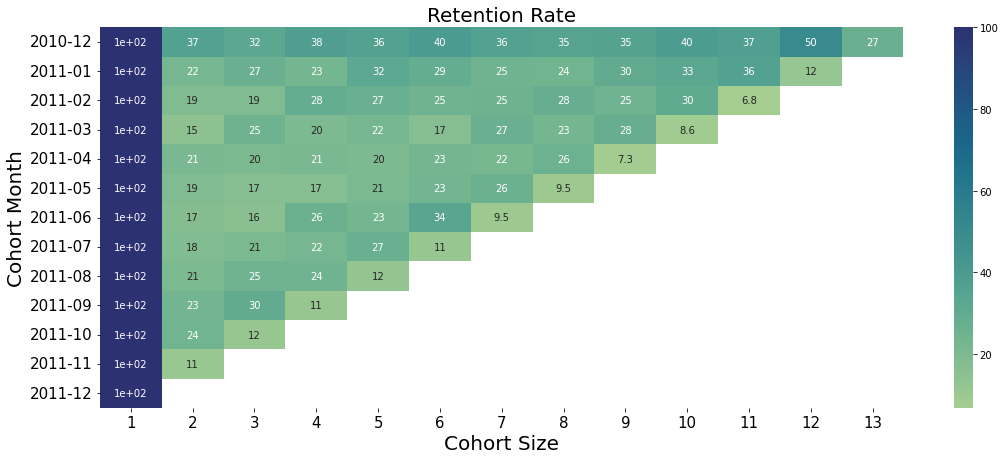

In [15]:
plt.figure(figsize = (18, 7))
sns.heatmap(retention, annot = True, cmap = "crest")
plt.title("Retention Rate", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cohort Size", size = 20)
plt.ylabel("Cohort Month", size = 20)
plt.show()

### Cohort Metrics Average Quantity

In [16]:
average_quantity = online.groupby(["CohortMonth", "CohortIndexMonth"])["Quantity"].agg(["mean"]).reset_index()
average_quantity_pivot = average_quantity.pivot(index = "CohortMonth",
                                                columns = "CohortIndexMonth",
                                                values = "mean")
average_quantity_pivot.round(2)

CohortIndexMonth,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.94,15.57,15.59,15.76,13.51,14.82,15.96,15.50,18.09,17.58,18.87,13.39,15.25
2011-01-01,17.25,13.32,12.62,15.15,12.78,15.27,14.89,14.85,11.57,10.51,9.42,9.96,NaN
2011-02-01,11.11,13.54,19.03,11.99,12.28,12.26,13.54,13.33,10.85,12.32,13.39,NaN,NaN
2011-03-01,9.90,11.68,13.27,10.09,14.29,12.95,13.40,13.74,11.17,9.47,NaN,NaN,NaN
2011-04-01,9.99,10.39,9.77,11.85,11.80,8.59,9.90,9.48,7.45,NaN,NaN,NaN,NaN
2011-05-01,11.34,9.63,14.09,12.76,11.14,8.69,10.64,109.93,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.58,14.53,10.82,13.55,10.56,9.82,9.41,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.84,13.75,7.31,8.09,6.12,7.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.03,6.17,5.41,6.15,7.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
average_quantity_pivot.index = pd.to_datetime(average_quantity_pivot.index)
average_quantity_pivot.index = average_quantity_pivot.index.strftime("%Y-%m")

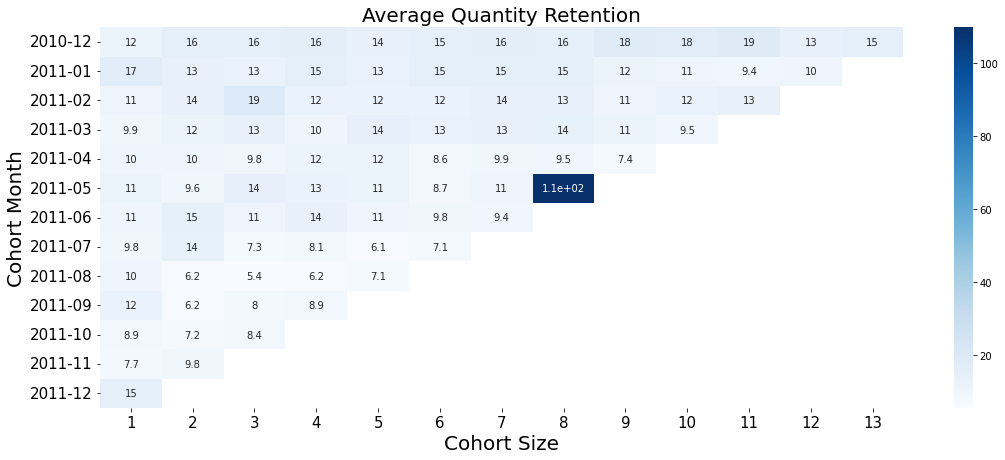

In [18]:
plt.figure(figsize = (18, 7))
sns.heatmap(average_quantity_pivot, annot = True, cmap = "Blues")
plt.title("Average Quantity Retention", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cohort Size", size = 20)
plt.ylabel("Cohort Month", size = 20)
plt.show()

In [19]:
cohort_sizes_quantity = average_quantity_pivot.iloc[:, 0]

retention_quantity = average_quantity_pivot.divide(cohort_sizes_quantity, axis = 0)

retention_quantity = retention_quantity.round(3) * 100

retention_quantity

CohortIndexMonth,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,130.4,130.6,132.0,113.1,124.1,133.7,129.9,151.5,147.2,158.1,112.1,127.7
2011-01,100.0,77.2,73.2,87.8,74.1,88.5,86.3,86.1,67.1,60.9,54.6,57.7,NaN
2011-02,100.0,121.9,171.3,107.9,110.6,110.4,121.9,120.0,97.7,110.9,120.6,NaN,NaN
2011-03,100.0,117.9,133.9,101.9,144.3,130.8,135.3,138.8,112.8,95.7,NaN,NaN,NaN
2011-04,100.0,104.0,97.8,118.6,118.1,86.0,99.1,94.9,74.6,NaN,NaN,NaN,NaN
2011-05,100.0,84.9,124.2,112.5,98.2,76.6,93.8,969.3,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,137.3,102.3,128.1,99.8,92.8,89.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,139.8,74.3,82.2,62.2,71.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,61.5,54.0,61.3,70.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recency, frequency, monetary (RFM) segmentation

**Create Spend Column**

In [20]:
online["Spend"] = online["UnitPrice"] * online["Quantity"]
online.sample(5)

,CustomerID,InvoiceNo,InvoiceDate,UnitPrice,Quantity,InvoiceMonth,CohortMonth,CohortIndexMonth,InvoiceDay,CohortDay,CohortIndexDay,Spend
18314,12766.0,537818,2010-12-08 13:53:00,7.95,4,2010-12-01,2010-12-01,1,2010-12-08,2010-12-08,1,31.8
31823,15822.0,539015,2010-12-15 13:38:00,0.85,24,2010-12-01,2010-12-01,1,2010-12-15,2010-12-15,1,20.4
198327,16497.0,554030,2011-05-20 13:56:00,1.65,12,2011-05-01,2011-01-01,5,2011-05-20,2011-01-10,131,19.8
450170,14367.0,575169,2011-11-08 17:21:00,2.08,20,2011-11-01,2011-03-01,9,2011-11-08,2011-03-08,241,41.6
184472,13990.0,552692,2011-05-10 15:19:00,1.45,10,2011-05-01,2011-05-01,1,2011-05-10,2011-05-10,1,14.5


In [21]:
rfm = online[["CustomerID", "InvoiceDay", "InvoiceNo", "Spend"]]

**In the dataset, the last order date is December 09, 2011, we have used this date as NOW date to calculate recency.**

In [22]:
now = dt.datetime(2011,12,9)

In [23]:
rfm_table = rfm.groupby("CustomerID").agg({"InvoiceDay": lambda x: (now - x.max()).days,  # Recency
                                           "InvoiceNo": lambda x: x.count(), # Frequency
                                           "Spend":      lambda x: x.sum()}) # Monetary

rfm_table.columns = ["Recency", "Frequency", "Monnetary"]
rfm_table.sample(5)

,Recency,Frequency,Monnetary
CustomerID,,,
15618.0,32,45,776.851
18064.0,133,7,814.000
14888.0,207,20,369.200
15187.0,1,91,4777.180
15776.0,133,18,241.620


**RFM Statistics**

In [24]:
rfm_table.describe()

,Recency,Frequency,Monnetary
count,4338.000000,4338.000000,4338.000000
mean,92.059474,91.720609,2054.266460
std,100.012264,228.785094,8989.230441
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,307.415000
50%,50.000000,41.000000,674.485000
75%,141.750000,100.000000,1661.740000
max,373.000000,7847.000000,280206.020000


**Calculate monetary quartiles (q=4)**

In [25]:
rfm_table["Monetary_Quanrtile"] = pd.qcut(rfm_table["Monnetary"],
                                          q = 4,
                                          labels = range(1, 5))
rfm_table.sample(5)

,Recency,Frequency,Monnetary,Monetary_Quanrtile
CustomerID,,,,
16856.0,14,2,35.40,1
16932.0,53,53,161.94,1
15503.0,362,70,147.09,1
16774.0,67,48,661.52,2
14758.0,144,71,1484.06,3


**Calculate recency deciles (q=4)**

In [26]:
rfm_table["Recency_Quartile"] = pd.qcut(rfm_table["Recency"], 
                                        q = 4, 
                                        labels = list(range(4, 0, -1)))
rfm_table.sample(5)

,Recency,Frequency,Monnetary,Monetary_Quanrtile,Recency_Quartile
CustomerID,,,,,
16556.0,66,207,3313.79,4,2
14381.0,52,56,202.68,1,2
13012.0,9,89,1661.84,4,4
16710.0,19,402,2483.04,4,3
15341.0,80,17,2020.52,4,2


**Calculate frequency quartiles (q=4)**

In [27]:
rfm_table["Frequency_Quartile"] = pd.qcut(rfm_table["Frequency"],
                                          q = 4,
                                          labels = range(1, 5))
rfm_table.sample(5)

,Recency,Frequency,Monnetary,Monetary_Quanrtile,Recency_Quartile,Frequency_Quartile
CustomerID,,,,,,
14044.0,26,209,652.82,2,3,4
16956.0,17,16,308.74,2,4,1
13854.0,8,110,8109.52,4,4,4
15117.0,14,79,1551.78,3,4,3
13217.0,122,4,533.98,2,2,1


In [28]:
rfm_table.columns = ["Recency", "Frequency", "Monetary", "Recency_Quartile", "Frequency_Quartile", "Monetary_Quanrtile"]
rfm_table.sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile
CustomerID,,,,,,
15985.0,123,37,1142.42,3,2,2
16139.0,18,31,635.41,2,3,2
12866.0,283,26,559.12,2,1,2
14538.0,64,19,388.25,2,2,2
16287.0,169,8,142.50,1,1,1


**Building RFM segments**

In [29]:
rfm_table["Monetary"] = rfm_table["Monetary"].astype("int")

In [30]:
def rfm_seg(x):
    return str(x["Recency_Quartile"]) + str(x["Frequency_Quartile"]) + str(x["Monetary_Quanrtile"])

rfm_table["RFM_Segment"] = rfm_table.apply(rfm_seg, axis = 1)
rfm_table["RFM_Score"] = rfm_table[["Recency_Quartile", "Frequency_Quartile", "Monetary_Quanrtile"]].sum(axis = 1)
rfm_table.sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
17449.0,2,277,2520,4,4,4,444,12
12734.0,352,4,110,1,1,1,111,3
15113.0,9,100,3609,4,4,3,443,11
12731.0,23,274,18895,4,3,4,434,11
17506.0,75,14,302,1,2,1,121,4


**RFM Segments Analysis**

In [31]:
# Top 10 RFM Segments
rfm_10 = rfm_table["RFM_Segment"].value_counts().head(10).to_frame().reset_index()
rfm_10.columns = ["RFM", "Customers"]
rfm_10

,RFM,Customers
0,444,440
1,111,385
2,434,222
3,212,206
4,121,181
5,323,169
6,333,168
7,222,165
8,343,148
9,232,126


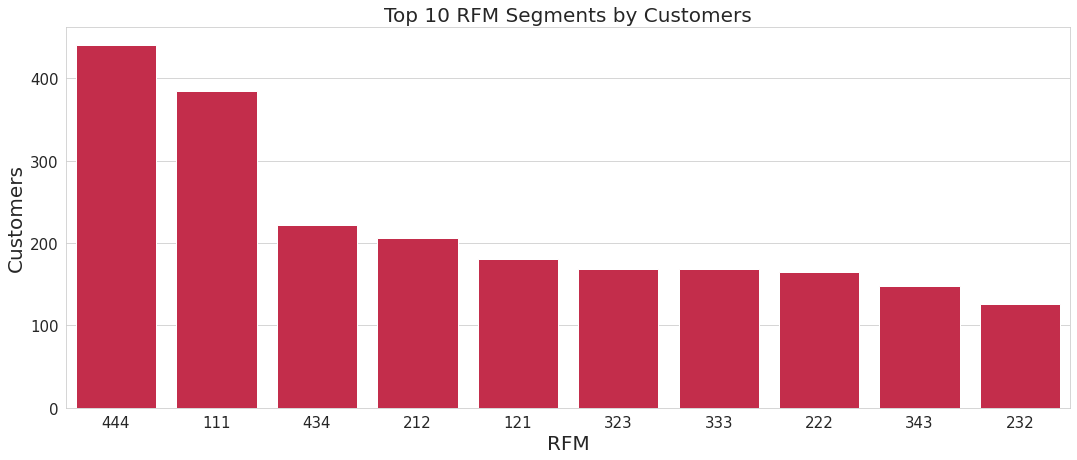

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 7))
sns.barplot(x = "RFM", y = "Customers", data = rfm_10, color = "crimson")
plt.title("Top 10 RFM Segments by Customers", size = 20)
plt.xlabel("RFM", size = 20)
plt.ylabel("Customers", size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

**Summary Metrics per RFM Score**

In [33]:
sm_rfm = rfm_table.groupby("RFM_Score")[["Recency", "Frequency", "Monetary"]].agg(["mean"]).reset_index()
sm_rfm                                        

,RFM_Score,Recency,Frequency,Monetary
,,mean,mean,mean
0,3,260.355844,8.233766,158.844156
1,4,174.166234,13.677922,238.537662
2,5,153.305609,21.350097,368.191489
3,6,95.637931,28.017241,823.316810
4,7,79.267699,38.730088,759.878319
5,8,63.721133,56.962963,993.629630
6,9,45.600484,80.113801,1810.196126
7,10,31.647196,112.654206,2057.799065
8,11,20.394937,188.020253,4071.265823


**Group RFM into named segments**

In [34]:
def rfm_nam(x):
    if x >= 9:
        return "Gold"
    elif x >= 5 and x < 9:
        return "Silver"
    else:
        return "Bronze"

rfm_table["General_Segment"] = rfm_table["RFM_Score"].apply(rfm_nam)
rfm_table.head()


,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12346.0,325,1,77183,4,1,1,411,6,Silver
12347.0,2,182,4310,4,4,4,444,12,Gold
12348.0,75,31,1797,4,2,2,422,8,Silver
12349.0,18,73,1757,4,3,3,433,10,Gold
12350.0,310,17,334,2,1,1,211,4,Bronze


**Summary Metrics by General_Segments**

In [35]:
sm_gs = rfm_table.groupby("General_Segment")[["Recency", "Frequency", "Monetary"]].agg(["mean"])
sm_gs

,Recency,Frequency,Monetary
,mean,mean,mean
General_Segment,,,
Bronze,217.261039,10.955844,198.690909
Gold,25.865752,191.979714,4405.964200
Silver,99.742072,35.776956,725.113636


**Q. Who are my best customers?**

In [36]:
rfm_table[rfm_table["RFM_Segment"] == "444"].sort_values(by = "Monetary", ascending = False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
14646.0,1,2076,280206,4,4,4,444,12,Gold
18102.0,0,431,259657,4,4,4,444,12,Gold
17450.0,8,337,194550,4,4,4,444,12,Gold
14911.0,1,5675,143825,4,4,4,444,12,Gold
14156.0,9,1400,117379,4,4,4,444,12,Gold


**Q Which customers are at the verge of churning?**

In [37]:
rfm_table[rfm_table["Recency"] <= 2].sort_values(by = "Monetary", ascending = False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
14646.0,1,2076,280206,4,4,4,444,12,Gold
18102.0,0,431,259657,4,4,4,444,12,Gold
16446.0,0,3,168472,4,4,1,441,9,Gold
14911.0,1,5675,143825,4,4,4,444,12,Gold
17511.0,2,963,91062,4,4,4,444,12,Gold


**Q. Who are the lost customers?**

In [38]:
rfm_table[rfm_table["RFM_Segment"] == "111"].sort_values(by = "Recency", ascending = False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
13065.0,373,14,205,1,1,1,111,3,Bronze
13747.0,373,1,79,1,1,1,111,3,Bronze
16048.0,373,8,256,1,1,1,111,3,Bronze
15350.0,373,5,115,1,1,1,111,3,Bronze
16583.0,373,14,233,1,1,1,111,3,Bronze


**Q. Who are loyal customers?**

In [39]:
rfm_table[rfm_table["Frequency_Quartile"] >= 3].sort_values(by = "Monetary", ascending = False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quanrtile,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12415.0,24,714,124914,4,3,4,434,11,Gold
16029.0,38,242,81024,4,3,4,434,11,Gold
12346.0,325,1,77183,4,1,1,411,6,Silver
15749.0,235,10,44534,4,1,1,411,6,Silver
12931.0,21,82,42055,4,3,3,433,10,Gold


### Data Preprocessing for Clustering

**Managing skewed variables**

Recency

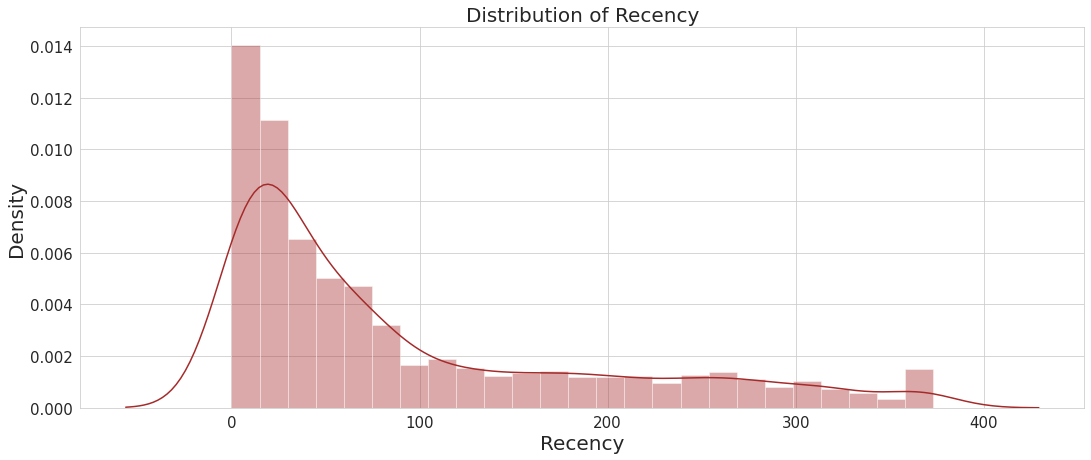

In [40]:
plt.figure(figsize = (18, 7))
sns.distplot(rfm_table["Recency"], color = "brown")
plt.title("Distribution of Recency", size = 20)
plt.xlabel("Recency", size = 20)
plt.ylabel("Density", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

Frequency

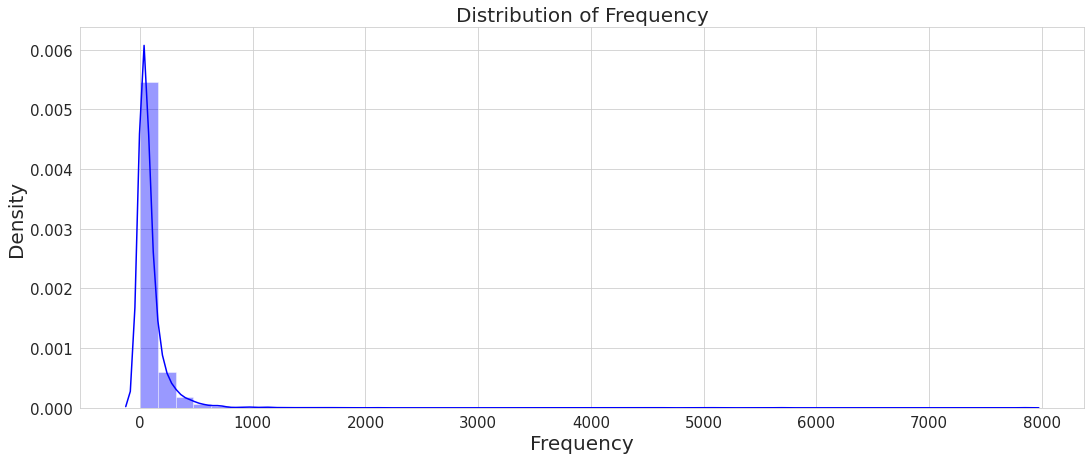

In [41]:
plt.figure(figsize = (18, 7))
sns.distplot(rfm_table["Frequency"], color = "blue")
plt.title("Distribution of Frequency", size = 20)
plt.xlabel("Frequency", size = 20)
plt.ylabel("Density", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

Monetary

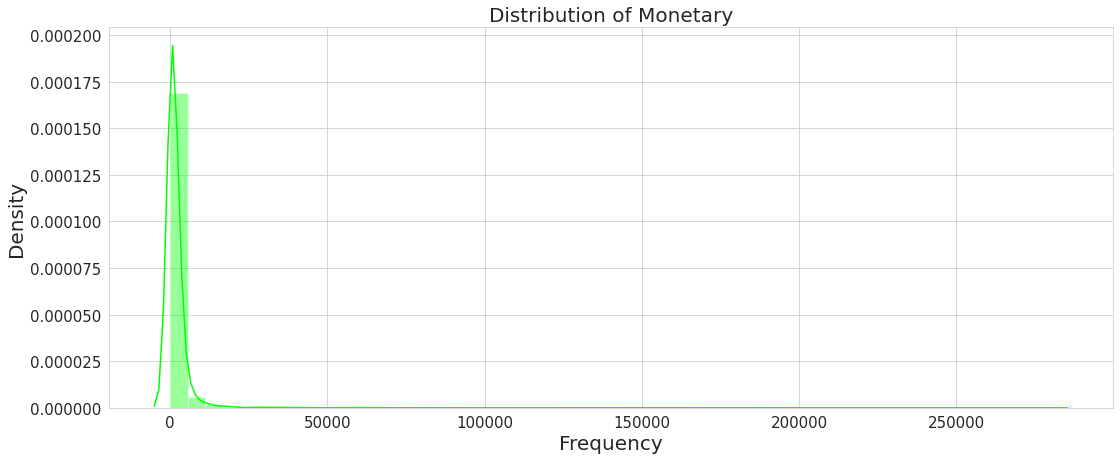

In [42]:
plt.figure(figsize = (18, 7))
sns.distplot(rfm_table["Monetary"], color = "lime")
plt.title("Distribution of Monetary", size = 20)
plt.xlabel("Frequency", size = 20)
plt.ylabel("Density", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

**Log Transformation Frequency**

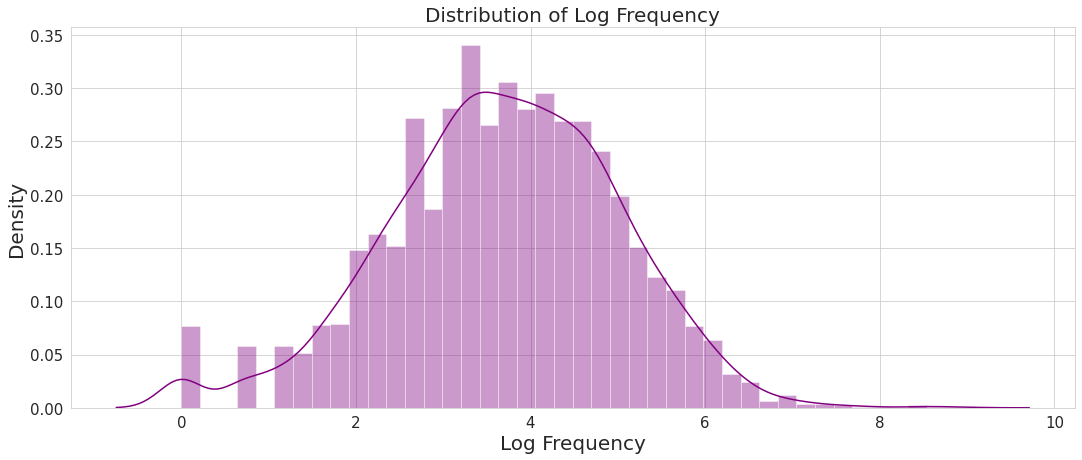

In [43]:
freq_log = np.log(rfm_table["Frequency"])
plt.figure(figsize = (18, 7))
sns.distplot(freq_log, color = "purple")
plt.title("Distribution of Log Frequency", size = 20)
plt.xlabel("Log Frequency", size = 20)
plt.ylabel("Density", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [44]:
rfm_table_copy = rfm_table[["Recency", "Frequency", "Monetary"]]
rfm_table_copy.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183
12347.0,2,182,4310
12348.0,75,31,1797
12349.0,18,73,1757
12350.0,310,17,334


**Preprocessing Pipeline**

In [45]:
# Log Transformation
rfm_log = np.log(rfm_table_copy)
rfm_log.replace([np.inf, -np.inf], np.nan, inplace=True)
rfm_log = rfm_log.dropna()
rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.783825,0.000000,11.253935
12347.0,0.693147,5.204007,8.368693
12348.0,4.317488,3.433987,7.493874
12349.0,2.890372,4.290459,7.471363
12350.0,5.736572,2.833213,5.811141


In [46]:
rfm_merge = pd.merge(rfm_table_copy, rfm_log, left_index=True, right_index=True)

In [47]:
rfm_merge = rfm_merge[["Recency_x", "Frequency_x", "Monetary_x"]]
rfm_merge.columns = ["Recency", "Frequency", "Monetary"]
rfm_merge.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183
12347.0,2,182,4310
12348.0,75,31,1797
12349.0,18,73,1757
12350.0,310,17,334


In [48]:
# Scaling
scaler = StandardScaler()
rfm_scale = scaler.fit_transform(rfm_log)
rfm_scale

array([[ 1.39902035, -2.7785995 ,  3.75341126],
       [-2.13318224,  1.16363719,  1.43993   ],
       [ 0.3815921 , -0.17722115,  0.73847116],
       ...,
       [-1.26394388, -0.89618644, -1.11543881],
       [-1.85184743,  2.24239864,  0.86111751],
       [-0.02071902,  0.43980025,  0.75612367]])

**Find Best Number of Clusters**

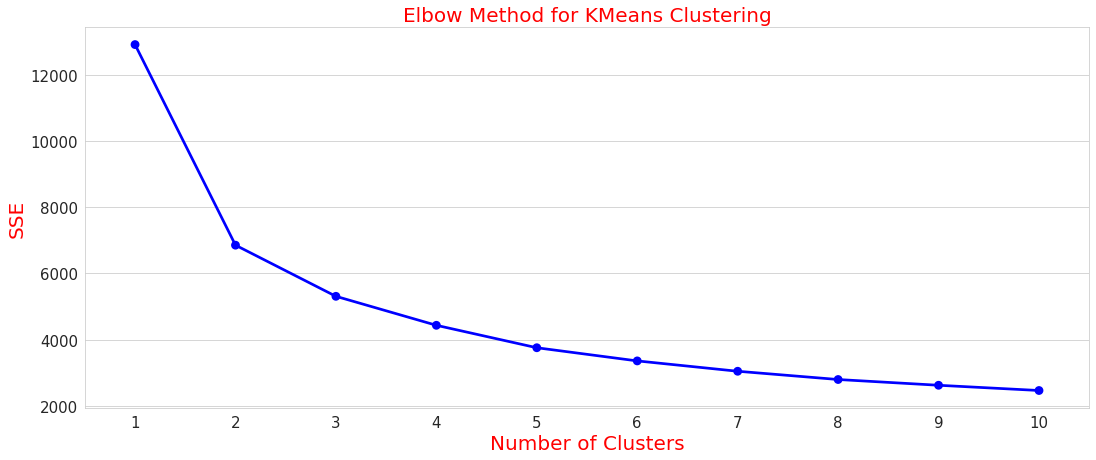

In [49]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(rfm_scale)
    sse[k] = kmeans.inertia_
    
plt.figure(figsize = (18, 7))
plt.title("Elbow Method for KMeans Clustering", size = 20, color = "red")
sns.pointplot(x = list(sse.keys()), y = list(sse.values()), color = "blue")
plt.xlabel("Number of Clusters", size = 20, color = "red")
plt.ylabel("SSE", size = 20, color = "red")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

### KMeans Clustering

In [50]:
kmeans = KMeans(n_clusters = 3,
                random_state = 42)

kmeans.fit(rfm_scale)

cluster_labels = kmeans.labels_

rfm_table_copy_k3 = rfm_merge.assign(Cluster = cluster_labels)

In [51]:
rfm_table_copy_k3.groupby("Cluster").agg({"Recency": "mean",
                                          "Frequency": "mean",
                                          "Monetary": "mean"})

,Recency,Frequency,Monetary
Cluster,,,
0,72.831579,66.263712,1167.828809
1,168.649042,14.559154,291.567746
2,12.920812,246.320812,5715.197970


**Profile and interpret segments**

In [52]:
rfm_scale = pd.DataFrame(rfm_scale, 
                         index = rfm_merge.index, 
                         columns = rfm_merge.columns)

rfm_scale["Clusters"] = rfm_table_copy_k3["Cluster"]

**Prepare Data for Snake Plot**

In [53]:
rfm_scale_melt = pd.melt(rfm_scale.reset_index(),
                         id_vars = ["CustomerID", "Clusters"],
                         value_vars = ["Recency", "Frequency", "Monetary"],
                         var_name = "Attribute",
                         value_name = "Value")
rfm_scale_melt.head()

,CustomerID,Clusters,Attribute,Value
0,12346.0,0,Recency,1.399020
1,12347.0,2,Recency,-2.133182
2,12348.0,0,Recency,0.381592
3,12349.0,0,Recency,-0.608623
4,12350.0,1,Recency,1.366234


**Visualize a Snake Plot**

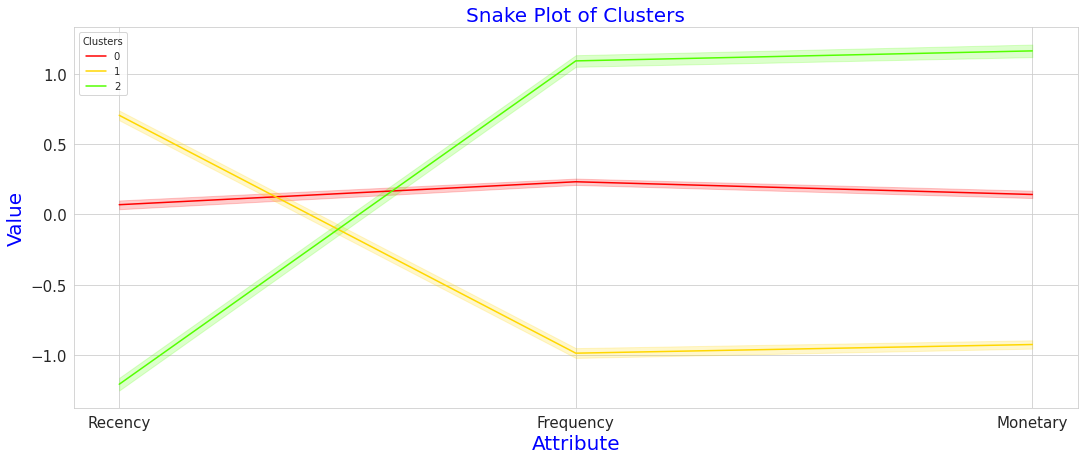

In [54]:
plt.figure(figsize = (18, 7))
sns.lineplot(x = "Attribute", y = "Value", hue = "Clusters", data = rfm_scale_melt, palette = "prism")
plt.title("Snake Plot of Clusters", color = "blue", size = 20)
plt.xlabel("Attribute", size = 20, color = "blue")
plt.ylabel("Value",size = 20, color = "blue")
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

**Calculate relative importance of each attribute**

In [55]:
# Calculate average RFM values for each cluster
cluster_avg = rfm_table_copy_k3.groupby("Cluster").mean()

# Calculate average RFM values for the total customer population
population_avg = rfm_merge.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = (cluster_avg / population_avg) - 1

relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,-0.22,-0.26,-0.39
1,0.82,-0.84,-0.85
2,-0.86,1.76,2.01


**Plot relative importance heatmap**

In [56]:
# set font size
sns.set(font_scale=1.4)

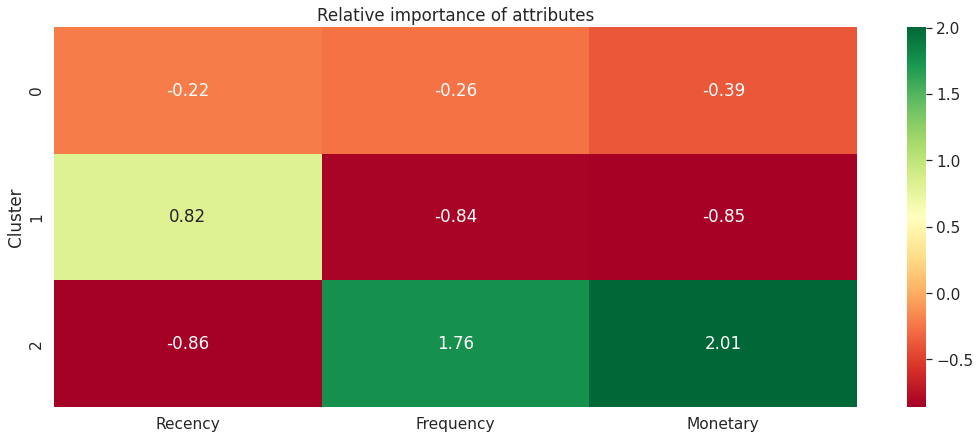

In [57]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(18, 7))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()